In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import pandas as pd

from aiutils import copy_logistic_model, load
from actioncard import Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch
from config import GameConfig
from enums import StartingSplit, FeatureType
from env import DefaultEnvironment
from mcts import GameTree 
from mctsrunner import train_mcts
from mctsutils import *
from player import init_players
from rollout import LogisticRegressionEnsembleRollout
from victorycard import Province

In [3]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

## Full Dominion MCTS ##

In [30]:
tree_name = 'r-r-mcts-bm-100k-srat-base-default-ucb1-cdecay'
rollout_name = 'mlog-10k-base-default-bm'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [31]:
default_kingdom = [Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch]

In [32]:
# C = lambda x: max(1e-2, min(0.5, 1 / np.sqrt(x)))
C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
# C = lambda x: 1
tree = GameTree(train=True, C=C, selection='ucb1', skip_level=False)

In [33]:
config = GameConfig(sandbox=False, num_players=2, must_include=default_kingdom)
# players = init_players(['UCT', 'DW'], tree=tree, rollout_type='mlog')
player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [34]:
rollout = LogisticRegressionEnsembleRollout(train=False)
agent.rollout = rollout

In [35]:
model_name = 'base-default-warm-start'
model_path = os.path.join(model_dir, model_name)
model = load(model_path)
rollout.models[8] = copy_logistic_model(model)

In [36]:
dataset_name = 'train-bm-bm-1k-full-base-default'
dataset_path = os.path.join(project_root, 'datasets', dataset_name)
X, y = load(dataset_path)
train_y = y.copy()
train_y[train_y<0] = 0

In [37]:
filtered_X_idxs = [(i, x) for i, x in enumerate(X) if x[idxs[Province]] > 6]
filtered_X_idxs = [list(t) for t in zip(*filtered_X_idxs)]
filtered_X = filtered_X_idxs[1]
filtered_y = train_y[filtered_X_idxs[0]]
assert len(filtered_X) == len(filtered_y)
len(filtered_y)

17386

In [38]:
model_name = 'default-mlog'
warm_model = load(os.path.join(model_dir, model_name))['models']

In [39]:
for i, model in warm_model.items():
    if i==0 or i == 8:
        continue
    coef = model.coef_ 
    cold_model = rollout.models[i]
    cold_model.coef_ = np.zeros((1, 51))
    cold_model.intercept_ = 0
    cold_model.classes_ = np.array([0, 1])
    cold_model.coef_[0][:7] = coef[0][:7]
    cold_model.coef_[0][17:24] = coef[0][7:14]
    cold_model.coef_[0][34:41] = coef[0][14:]

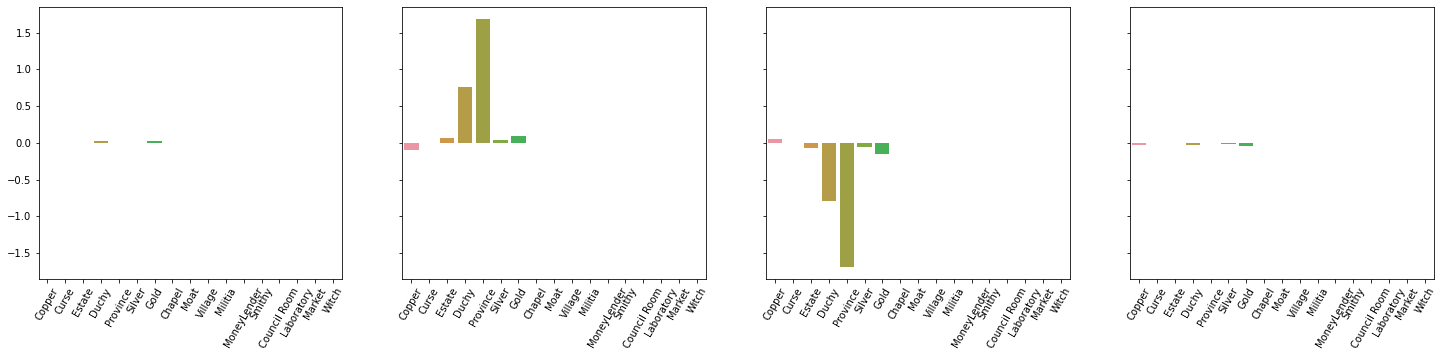

In [40]:
plot_model = agent.rollout.models[1]
agent_weights = plot_model.coef_[0][17:34]
opp_weights = plot_model.coef_[0][34:]
supply_weights = plot_model.coef_[0][:17]
player_weight_diffs = agent_weights + opp_weights
cards = list(str(k()) for k in idxs.keys())

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])

for ax in axes: 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

In [41]:
train_mcts(env=env, tree=tree, epochs=100000, train_epochs_interval=sys.maxsize, save_epochs=10000, path=tree_path, rollout_path=rollout_path, scoring='score_ratio')

100%|██████████| 100000/100000 [48:44<00:00, 34.19it/s]


In [21]:
tree = GameTree.load(path=tree_path, train=False)

## Sandbox MCTS Training ##

In [4]:
tree_name = 'r-r-mcts-bm-warm-start-10k-srat-sandbox-ucb1-cdecay'
rollout_name = 'default-sandbox-mlog'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [5]:
dataset_name = 'train-bm-bm-1k-full'
data_path = os.path.join(project_root, 'datasets', dataset_name)
raw_data = load(data_path)
X, y = raw_data[0], raw_data[1]
train_y = y.copy()
train_y[train_y<0] = 0

In [6]:
# C = lambda x: max(1e-2, min(0.5, 1 / np.sqrt(x)))
C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
# C = lambda x: 1
tree = GameTree(train=True, C=C, selection='ucb1', _skip_level=False)

In [7]:
config = GameConfig(sandbox=True, num_players=2)
# players = init_players(['UCT', 'DW'], tree=tree, rollout_type='mlog')
player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [8]:
rollout = player.rollout
model_name = 'default-bm-log-pred'
model_path = os.path.join(model_dir, model_name)
model = load(model_path)
rollout.models[8] = copy_logistic_model(model)

In [9]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}
cards = list(idxs.keys())

In [10]:
filtered_X_idxs = [(i, x) for i, x in enumerate(X) if x[idxs['Province']] > 6]
filtered_X_idxs = [list(t) for t in zip(*filtered_X_idxs)]
filtered_X = filtered_X_idxs[1]
filtered_y = train_y[filtered_X_idxs[0]]
assert len(filtered_X) == len(filtered_y)
len(filtered_y)

17506

In [11]:
for i, x in enumerate(filtered_X): 
    rollout.buffers[8].store(x, filtered_y[i])

In [12]:
rollout.train = False

In [13]:
train_mcts(env=env, tree=tree, epochs=10000, train_epochs_interval=500, save_epochs=1000, path=tree_path, rollout_path=rollout_path)

  5%|▌         | 514/10000 [04:47<1:28:19,  1.79it/s]


KeyboardInterrupt: 

In [35]:
node = tree._root
get_depth(node)

15

In [36]:
node = tree._root.children[0].children[0]

In [41]:
tree._root.children[0].children

[None<--n: 90, v: 1645, c: None-->['Copper', 'Estate', 'None'],
 None<--n: 339, v: 6634, c: None-->['Copper', 'Estate', 'None'],
 None<--n: 315, v: 6581, c: None-->['Copper', 'Estate', 'None'],
 None<--n: 61, v: 1308, c: None-->['Copper', 'Estate', 'None']]

In [37]:
L = get_most_visited_paths_at_depth(node, 4, 10)

In [49]:
get_buy_sequence(L[3])

[None, Copper, Duchy, Copper, None]

In [38]:
node.children[2].children

[None<--n: 64, v: 1219, c: Copper-->['Copper', 'Estate', 'Duchy', 'Silver', 'None'],
 None<--n: 5, v: 68, c: Estate-->['Copper', 'Estate', 'Duchy', 'Silver', 'None'],
 None<--n: 2, v: 22, c: None-->['Copper', 'Estate', 'Duchy', 'Silver', 'None']]

In [102]:
model_name = 'r-r-logistic-pred-1k-50'
model_path = os.path.join(model_dir, model_name)
plot_model = load(model_path)

<AxesSubplot:>

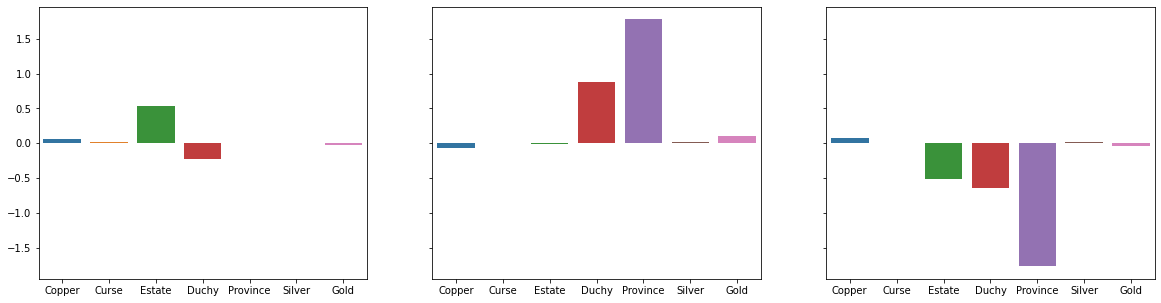

In [21]:
i=1
plot_model = player.rollout.models[i]
# plot_model = model

agent_weights = plot_model.coef_[0][7:14]
opp_weights = plot_model.coef_[0][14:]
supply_weights = plot_model.coef_[0][:7]
# cards = list(env.game.state.feature.idxs.keys())

f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])

In [106]:
agent_weights_comp = plot_model.coef_[0][7:14]
opp_weights_comp = plot_model.coef_[0][14:]
supply_weights_comp = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

<AxesSubplot:>

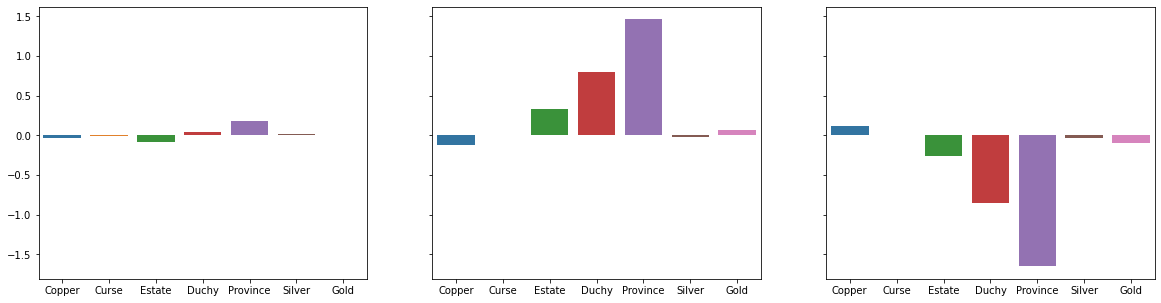

In [107]:
f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights_comp, ax=axes[0])
sns.barplot(x=cards, y=agent_weights_comp, ax=axes[1])
sns.barplot(x=cards, y=opp_weights_comp, ax=axes[2])